In [1]:
import numpy as np
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, PILToTensor, CenterCrop, ConvertImageDtype
from skimage import io
import torch
import torch.nn as nn
from einops import rearrange, repeat
import pandas as pd
import sys
sys.path.insert(0, '../utils/')
from dataset import ChestImage64
import os
import time
import datetime

from PIL import Image

import matplotlib.pyplot as plt
import csv

from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data import random_split, DataLoader, Dataset

In [2]:
# csv_path = "../64pxImages/train_labels_64p.csv"
# root_path = '../64pxImages'

csv_path = "../Data/256pxImages/train_labels_256p.csv" #I had to change \ to / for this but disregared if it is not an issue for you
root_path = "../Data/256pxImages/"


default_transform = ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1.transforms


data_transform = Compose([
    Resize((64, 64)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
myCSV = pd.read_csv(csv_path)
myCSV['EncodedLabels'] = ''
print(myCSV.shape)


# for i in range(4, myCSV.shape[1]-1):
#     myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + myCSV.iloc[:, i].astype(str) 
#     if i < myCSV.shape[1]-2:
#         myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + "," 

for i in range(4, myCSV.shape[1]-1):
    myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + myCSV.iloc[:, i].astype(str) 
    if i < myCSV.shape[1]-2:
        myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + "," 



# myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + "]"


# We can use the encodedlabels column as our labels for our data

# since we are not useing cross attention, pull out only the frontal images. 
frontalCSV = myCSV[myCSV['Frontal/Lateral'].str.contains("Frontal")]
frontalCSV.head()

filename = frontalCSV.iloc[1, 0]
print(filename)

label_test = frontalCSV['EncodedLabels'].iloc[0]

test_path = os.path.join(root_path, filename)


label_test = [int(x) for x in label_test.split(",")]

print("label_test: ", label_test)

image = io.imread(test_path)
print(type(image))
image = torch.tensor(image)
print(image.size())

(61266, 19)
Frontal/patient00004_study1_Frontal.png
label_test:  [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
<class 'numpy.ndarray'>
torch.Size([256, 256])


In [4]:
myCSV.head()

,256path,Patient,Study,Frontal/Lateral,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,EncodedLabels
0,Frontal/patient00002_study1_Frontal.png,patient00002,study1,Frontal,1,1,1,1,0,1,1,1,0,0,1,1,0,0,"1,1,1,1,0,1,1,1,0,0,1,1,0,0"
1,Lateral/patient00002_study1_Lateral.png,patient00002,study1,Lateral,1,1,1,1,0,1,1,1,0,0,1,1,0,0,"1,1,1,1,0,1,1,1,0,0,1,1,0,0"
2,Frontal/patient00004_study1_Frontal.png,patient00004,study1,Frontal,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"
3,Lateral/patient00004_study1_Lateral.png,patient00004,study1,Lateral,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"
4,Frontal/patient00005_study1_Frontal.png,patient00005,study1,Frontal,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"0,0,0,0,0,0,0,0,0,0,0,0,1,0"


torch.Size([3, 224, 224])
tensor([[[ 0.1254, -0.0801,  0.0056,  ...,  0.1939,  0.2453,  0.0398],
         [ 0.1083, -0.0116,  0.0227,  ...,  0.0569,  0.1426, -0.0629],
         [ 0.1083, -0.0116, -0.0116,  ...,  0.1597,  0.0056, -0.0801],
         ...,
         [-1.0390, -1.0219, -1.0390,  ..., -1.8097, -1.8097, -1.7925],
         [-1.0562, -1.0733, -1.0562,  ..., -1.8097, -1.7925, -1.7925],
         [-1.0390, -0.9877, -0.9877,  ..., -1.7925, -1.7754, -1.7583]],

        [[ 0.2577,  0.0476,  0.1352,  ...,  0.3277,  0.3803,  0.1702],
         [ 0.2402,  0.1176,  0.1527,  ...,  0.1877,  0.2752,  0.0651],
         [ 0.2402,  0.1176,  0.1176,  ...,  0.2927,  0.1352,  0.0476],
         ...,
         [-0.9328, -0.9153, -0.9328,  ..., -1.7206, -1.7206, -1.7031],
         [-0.9503, -0.9678, -0.9503,  ..., -1.7206, -1.7031, -1.7031],
         [-0.9328, -0.8803, -0.8803,  ..., -1.7031, -1.6856, -1.6681]],

        [[ 0.4788,  0.2696,  0.3568,  ...,  0.5485,  0.6008,  0.3916],
         [ 0.4614, 

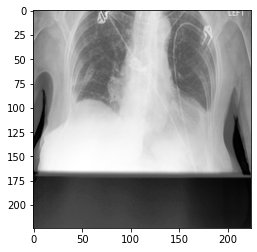

In [5]:
filenameTest = frontalCSV.iloc[0, 0]
testpath = os.path.join(root_path, filenameTest)
testimg = Image.open(testpath).convert('RGB')
#plt.imshow(testimg)
#testimg = torch.tensor(testimg)
testtransform = Compose([
    PILToTensor(),
    CenterCrop((224,224)),
    ConvertImageDtype(torch.float32),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
testimg = testtransform(testimg)
#testimg = testimg.resize_((3, 224, 224))
#testimg = repeat(testimg, "h w -> (repeat h) w", repeat = 3)
#testimg = rearrange(testimg, "(c h) w -> c h w", c = 3)
print(testimg.size())
print(testimg)

plt.imshow(testimg.numpy()[0], cmap='gray')

In [6]:
# load up the dataset
class CustomDataset(Dataset):
    def __init__(self, df, root_dir, label_col, transform = None):
        self.df = df
        self.root_dir = root_dir
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        if torch.is_tensor(index):
            index = index.tolist()

        # get the filename of the image
        filename = self.df.iloc[index, 0]
        label = self.df[self.label_col].iloc[index]

        if type(label) == str:
            label = [int(x) for x in label.split(",")]

        # load the image from disk
        path = os.path.join(self.root_dir, filename)
        #img = io.imread(path)
        img = Image.open(path).convert('RGB')

        label = torch.tensor(label)
        label = label.float()

        #img = torch.tensor(img)
        #img = img.resize_((224, 224))
        img = self.transform(img)


        #img = repeat(img, "h w -> (repeat h) w", repeat = 3)
        #img = rearrange(img, "(c h) w -> c h w", c = 3)
        img = img.float()


        #if self.transform:
            #label = self.transform(label)
            #img = self.transform(img)

        # return the image and its filename
        return img, label

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
def train_model(train_dataset, validation_dataset,config, benchmark=0.33):
    #, epochs=1
    start_time = time.time()
    
    learning_rate=config["lr"]
    batch_size=config["batch_size"]
    #dropout=config["d1"]
    epochs=config["epochs"]
    
    
    # batch accumulation parameter
    target_accumulation=64
    accum_iter = target_accumulation/batch_size  
    print(accum_iter)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=True)
    
    
    # information about the pretrained models is coming from this link: 
    #https://pytorch.org/vision/master/models.html


    # just use the default weights. These should yeild the best results
    weights = ViT_B_16_Weights.DEFAULT
    num_classes = 14
    feature_extraction = False
    model = vit_b_16(weights = weights)
    
    criterion = nn.BCEWithLogitsLoss()
    
    if feature_extraction: 
        for param in model.parameters():
            param.requires_grad = False

        # change the last layer to have the correct number of classes
        model.heads = nn.Sequential(nn.Linear(768, num_classes))
        model.heads.requires_grad_ = True
    else:
        model.heads = nn.Sequential(nn.Linear(768, num_classes))

    
    model.to(device)

    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) 
    
    training_losses = []
    validation_losses = []
    validation_accuracies =[]
    global v_running_loss #maybe not a good idea?

    
    for epoch in range(epochs):
        phase = 'train'
        # set the model to training mode
        model.train()
        running_loss = 0.0

        # zero the parameter gradients at the very beginning
        optimizer.zero_grad()

        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            # optimizer.zero_grad()

            # with torch.set_grad_enabled(phase == 'train'):
            # run the training data through the model
            outputs = model(inputs)

            #calculate the loss of the model
            loss = criterion(outputs, labels)

            #Gradient accumulation
            loss = loss / accum_iter
            loss.backward()

            running_loss += loss.item()

            # weights update
            if ((i + 1) % accum_iter == 0) or (i + 1 == len(train_loader)):
                optimizer.step()
                optimizer.zero_grad()

                if ((i + 1) / accum_iter) % 50 == 0:    # record loss and test validation set every 500 gradient accumulations
                    model.eval()
                    v_running_loss = 0.0
                    for v, data in enumerate(val_loader):
                        inputs, labels = data[0].to(device), data[1].to(device)
                        v_outputs = model(inputs)
                        v_loss = criterion(v_outputs, labels)
                        v_running_loss += v_loss.item()

                    print("Time: ", datetime.datetime.now().strftime("%H:%M:%S"), "\tepoch: ", epoch+1, "batch: ", i+1, "Training loss: ", running_loss, "Validation loss ", v_running_loss)
                    validation_losses.append(v_running_loss)
                    training_losses.append(running_loss)
                    running_loss = 0.0

            # once the validation has been completed, update the model
            #loss.backward()
            #optimizer.step()
            # set model back to training mode

    end_time = time.time()
    train_time = end_time - start_time
    print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
    print('Finished Training')
    
    #model_name= "vitb_model_e" + str(epochs) + f"_drop{dropout:.0e}" + f"_lr{learning_rate:.0e}" + "_bs "+ str(batch_size)
    model_name= "vitb_model_e" + str(epochs) + f"_lr{learning_rate:.0e}" + "_bs "+ str(batch_size)
    model_filepath="../Logging/" + model_name + ".pth"

    figure_path="../Logging/" + model_name + ".png"

    print(model_filepath)

    torch.save(model.state_dict(), model_filepath)

    fig, axs = plt.subplots()
    axs.plot(training_losses)
    axs.plot(validation_losses)
    axs.set_title("Losses")
    axs.set_xlabel("Mini Batchs")
    axs.set_ylabel("Loss")

    fig.suptitle(model_name)
    plt.savefig(figure_path, dpi=300)
    
    #return running_loss, v_running_loss, accuracy, epoch
    return running_loss, v_running_loss, epoch
    

In [9]:
testtransform = Compose([
    PILToTensor(),
    CenterCrop((224,224)),
    ConvertImageDtype(torch.float32),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
dataset = CustomDataset(frontalCSV, root_dir=root_path, label_col="EncodedLabels", transform=testtransform)


#print(type(dataset))

# split into test train validate
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.2 * len(dataset))


train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print("Train Length: ", len(train_dataset))
print("Validation Length: ", len(val_dataset))
print("Test Length: ", len(test_dataset))

#train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
#test_loader = DataLoader(test_dataset,batch_size=batchsize, shuffle=True)

Train Length:  21441
Validation Length:  3063
Test Length:  6126


{'epochs': 8, 'lr': 0.01, 'batch_size': 8}
Train Start. Iteration:  1
8.0
Time:  20:00:47 	epoch:  1 batch:  400 Training loss:  27.126993857324123 Validation loss  192.08266666531563
Time:  20:01:33 	epoch:  1 batch:  800 Training loss:  24.420667853206396 Validation loss  179.73428425192833
Time:  20:02:18 	epoch:  1 batch:  1200 Training loss:  23.7829272672534 Validation loss  177.49116991460323
Time:  20:03:04 	epoch:  1 batch:  1600 Training loss:  23.18638519756496 Validation loss  173.69454509019852
Time:  20:03:49 	epoch:  1 batch:  2000 Training loss:  22.04136843420565 Validation loss  166.09103685617447
Time:  20:04:35 	epoch:  1 batch:  2400 Training loss:  22.164128694683313 Validation loss  174.29386299848557
Time:  20:05:42 	epoch:  2 batch:  400 Training loss:  20.580457778647542 Validation loss  163.14294247329235
Time:  20:06:28 	epoch:  2 batch:  800 Training loss:  20.221951263025403 Validation loss  155.74600748717785
Time:  20:07:13 	epoch:  2 batch:  1200 Traini

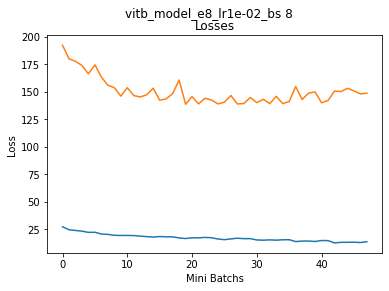

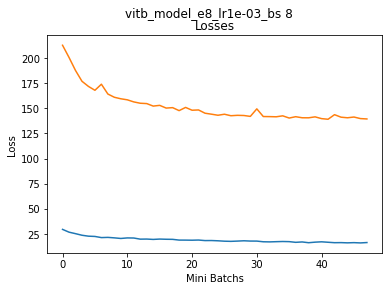

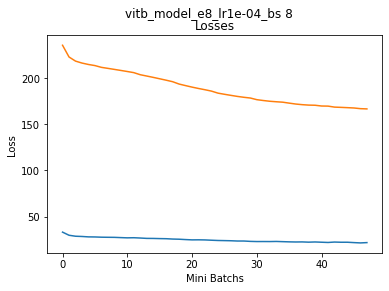

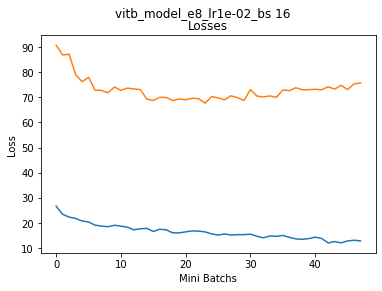

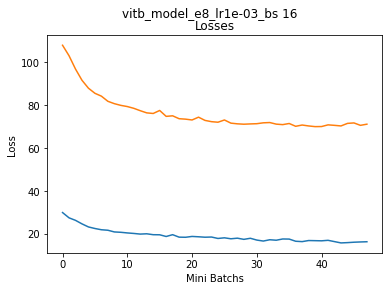

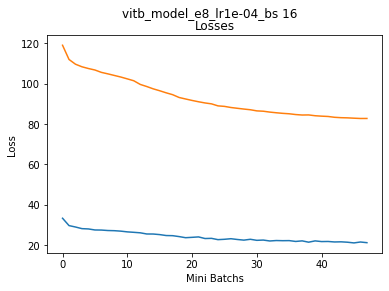

In [10]:
result_list = []

#Grid search parameters
#dropout=[0.2]
batch_size=[8,16]
learn_rate=[0.01,0.001,0.0001]
epochs=[8]


it=0
#for d in dropout:
for e in epochs:
    for bs in batch_size:
        for lr in learn_rate:

            it +=1 
            #config = {"d1": d,"lr": lr,"batch_size": bs}
            config = {"epochs": e, "lr": lr, "batch_size": bs}
            #config = {"lr": lr,"batch_size": bs}

            print(config)
            print("Train Start. Iteration: ",it)
            t_loss,v_loss, end_Ep=train_model(train_dataset, val_dataset,config)
            #t_loss,v_loss, acc, end_Ep=train_model(train_dataset, val_dataset,config)

            list_row= str(bs) + "," + str(lr) + "," + str(t_loss) + "," + str(v_loss) + "," + str(end_Ep)
            #list_row= str(bs) + "," + str(lr) + "," + str(t_loss) + "," + str(v_loss) + "," + str(end_Ep), + "," + str(acc)

            t_list=[list_row]  
            result_list.append(t_list)


with open('opt_resultss.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    wr.writerow(result_list)